In [77]:
import matplotlib.pyplot as plt
from typing import List, Dict, Callable
import numpy as np
import pandas as pd
import json
import os
import my_utils
import re

In [78]:
DPI=300

In [79]:
root_directory = os.path.dirname("../")
logs_directory = os.path.join(root_directory, "logs")
expirements_logs = os.path.join(logs_directory, "logs_2024-05-12T10:18:55")
current_dir = os.path.dirname(".")
plots_directory = os.path.join(current_dir, "plots")
testcase = "throughput" # "throughput" or "goodput"

## Goodput

In [80]:
def extract_total_recv_bytes_from_file(filename: str) -> int:
    """ bytes recv
    """
    with open(filename, "r") as f:
        lines = f.readlines()
    if len(lines) == 0:
        return pd.DataFrame()
    to_return = 0
    hash_set = set() # Avoid duplicates
    for line in lines:
        line = line.strip()
        if re.match(r".*McMPQUICConnClient.*", line) is None:
            continue
        line = line.split("app_conn: ")[1]
        if line in hash_set:
            continue
        hash_set.add(line)
        splitted = line.split("received: ")
        recd_bytes = int(splitted[1].split(",")[0])
        to_return += recd_bytes
    return to_return

def extract_goodput_data_for_client(role_logs: str) -> int:
    trace_files = [f for f in os.listdir(role_logs) if f.startswith("client.log")]
    if len(trace_files) == 0:
        return pd.DataFrame(columns=["goodput", "nb_paths", "implementation"])
    elif len(trace_files) > 1:
        raise Exception("More than one client log file found")
    return extract_total_recv_bytes_from_file(os.path.join(role_logs, trace_files[0]))

def extract_goodput_data_per_run(run_logs: str, extract_nb_paths) -> pd.DataFrame:
    if extract_nb_paths is None:
        raise Exception("extract_nb_paths is None")
    nb_paths = extract_nb_paths(os.path.join(run_logs, "server", "server.log"))
    elapsed_secondds = my_utils.get_transfer_time_client(os.path.join(run_logs, "client", "time.json"))
    client_recvd = extract_goodput_data_for_client(os.path.join(run_logs, "client"))
    client_recvd_bits = client_recvd * 8
    goodput = client_recvd_bits / 1024**3 / elapsed_secondds
    return pd.DataFrame({"goodput": goodput, "nb_paths": nb_paths}, index=[0])

def extract_goodput_per_testcase(testcase_logs: str, extract_nb_paths=Callable[[str], int]) -> pd.DataFrame:
    runs_dirs = [f for f in os.listdir(testcase_logs) if f.isdigit()]
    df = pd.DataFrame(columns=["goodput", "nb_paths"])
    for run in runs_dirs:
        df_run = extract_goodput_data_per_run(os.path.join(testcase_logs, run), extract_nb_paths)
        df = pd.concat([df, df_run], ignore_index=True)
    return df

def extract_goodput_impl(implementation_logs: str, impl_name: str, extract_nb_paths=Callable[[str], int]) -> pd.DataFrame:
    """ goodput| nb_paths | implementation
    """
    df = extract_goodput_per_testcase(os.path.join(implementation_logs, testcase), extract_nb_paths)
    df["implementation"] = impl_name
    return df

def extract_goodput_from_info_logs(logs: List[str]) -> pd.DataFrame:
    df = pd.DataFrame(columns=["goodput", "nb_paths", "implementation"])
    for logs_dir in logs:
        logs_dir = os.path.join(logs_directory, logs_dir)
        for implemantation_logs in [dir for dir in os.listdir(logs_dir) if os.path.isdir(os.path.join(logs_dir, dir))]:
            impl_name = implemantation_logs.split("_")[0]
            if impl_name in ["mcmpquic", "mpquic"]:
                df_ret = extract_goodput_impl(os.path.join(logs_dir, implemantation_logs), impl_name, my_utils.mcmpquic_extract_nb_paths)
                df = pd.concat([df, df_ret], ignore_index=True)
            else:
                raise Exception(f"Unknown implementation {impl_name}")
    return df

In [81]:
goodput_df = extract_goodput_from_info_logs(["logs_2024-05-23T10:47:38", "logs_2024-05-23T15:10:07"])

In [82]:
def plot_goodput(ax: plt.Axes, df: pd.DataFrame):
    """Plots the goodput data in a DataFrame as error bars."""
    implementations = sorted(list(df["implementation"].unique()), reverse=True)
    fmts = ['*', 'p', 'h', 'H', 'd', '*', 'x', '+', '.']
    colors = [my_utils.get_color_for_impl(impl) for impl in implementations]
    all_nb_paths = list(df["nb_paths"].unique())
    all_nb_paths.sort()
    all_nb_paths = np.array(all_nb_paths)
    next_index = 0
    max_observed = 0
    for implementation in implementations:
        df_impl = df[df["implementation"] == implementation]
        y_data, yerr_data = [], []
        for nb_paths in all_nb_paths:
            throughput_values = df_impl[df_impl["nb_paths"] == nb_paths]["goodput"]
            throughput_values = throughput_values.to_numpy()
            if len(throughput_values) > 0:
                mean_value = np.mean(throughput_values)
                std_dev = np.std(throughput_values)
                y_data.append(mean_value)
                yerr_data.append(std_dev)
                max_observed = max(max_observed, mean_value + std_dev)
            else:
                y_data.append(0)
                yerr_data.append(0)
        fmt = fmts[next_index]
        ax.errorbar(
            all_nb_paths, y_data, yerr_data, linestyle='--', linewidth=1,
            capsize=2, elinewidth=1, fmt=fmt, color=colors[next_index], label=implementation)
        next_index += 1
    
    ax.set_xticks(all_nb_paths, all_nb_paths)
    ax.set_xlabel("Number of paths")
    ax.set_ylabel("Goodput [Gbps]")
    ax.grid(which='major', color='black', linewidth=.4, alpha=0.2, linestyle="dashed")  # Show the major grid
    ax.set_ylim(0, max_observed * 1.1)
    ax.legend(edgecolor='black', fancybox=False, shadow=False, framealpha=1)
    ax.tick_params(axis='x', which='minor', bottom=False)  # Disable the minor ticks on the x-axis

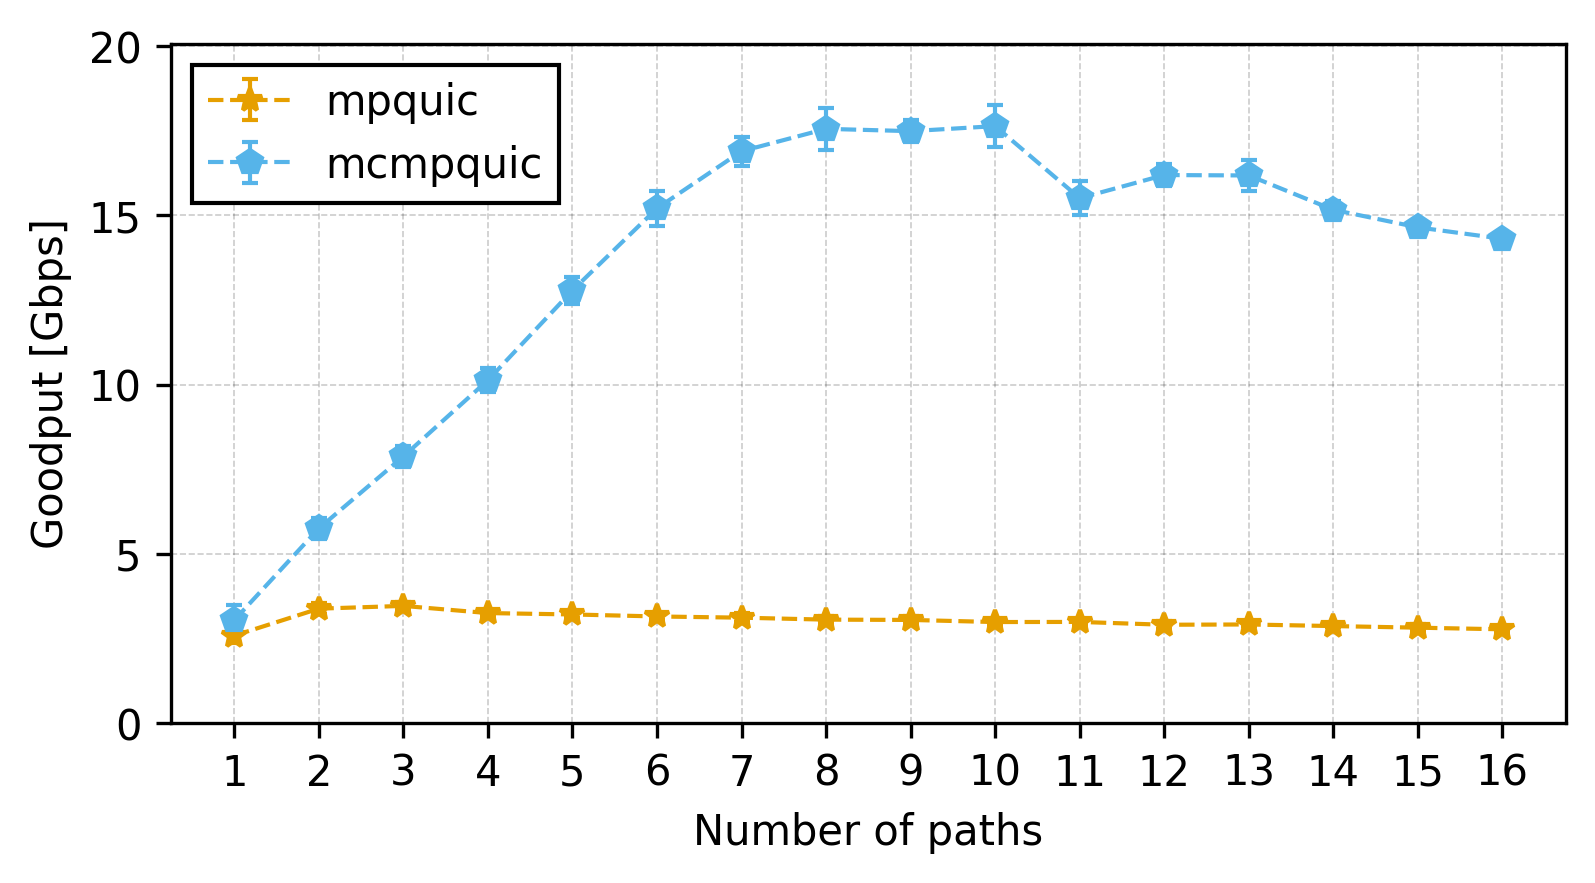

In [83]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6, 3), dpi=DPI)
plot_goodput(ax, goodput_df.copy())
plt.savefig(os.path.join(plots_directory, "goodput_filesize_boxplot.pdf"), format="pdf", bbox_inches='tight')
plt.savefig(os.path.join(plots_directory, "goodput_filesize_boxplot.svg"), format="svg", bbox_inches='tight')
plt.show()